In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("/kaggle/input/spam-email/spam.csv")

In [3]:
df.shape

(5572, 2)

In [4]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [5]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df["Category"] = df["Category"].map(lambda x: 1 if x == "spam" else 0)

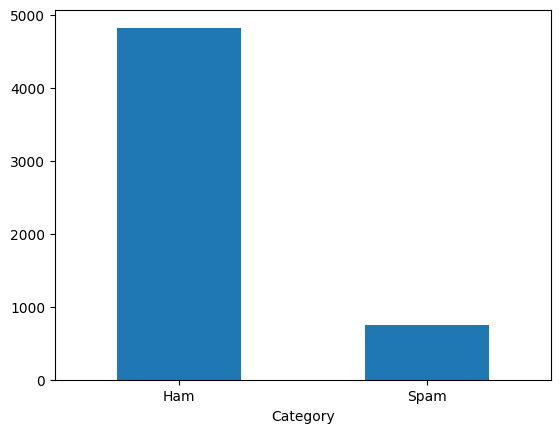

In [7]:
df["Category"].value_counts().plot(kind="bar")
plt.xticks(ticks=[0, 1], labels=["Ham", "Spam"], rotation = 0)
plt.show()

In [8]:
classes = df["Category"].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=df["Category"])
class_weights_dict = dict(zip(classes, class_weights))

In [9]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])

def lemmatize_series(series):
    return [lemmatize_text(x) for x in series]

lemmatizer_transformer = FunctionTransformer(lemmatize_series)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df["Message"], df["Category"], test_size = 0.4, shuffle = True, random_state = 42)

In [11]:
model = Pipeline([("lemmatizer", lemmatizer_transformer),
                 ("tfidf", TfidfVectorizer(stop_words = "english")),
                 ("clf", LogisticRegression(class_weight = class_weights_dict))])

In [12]:
model.fit(X_train, y_train)

Pipeline(steps=[('lemmatizer',
                 FunctionTransformer(func=<function lemmatize_series at 0x7b151312fb00>)),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight={0: 0.5774093264248704,
                                                  1: 3.7295850066934406}))])

In [13]:
y_predict = model.predict(X_test)

In [14]:
acc = accuracy_score(y_test, y_predict)

In [15]:
print(f"Model Accuracy: {acc*100:.2f}%")

Model Accuracy: 98.12%


In [16]:
cr = classification_report(y_test, y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1938
           1       0.91      0.96      0.93       291

    accuracy                           0.98      2229
   macro avg       0.95      0.97      0.96      2229
weighted avg       0.98      0.98      0.98      2229



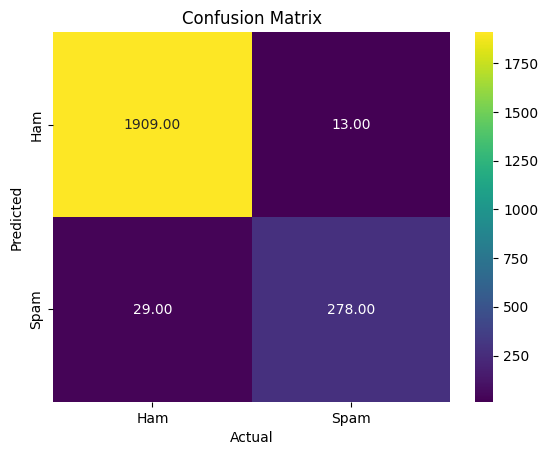

In [17]:
cm = confusion_matrix(y_predict, y_test)
sns.heatmap(cm, cmap = "viridis", annot = True, fmt = ".2f", xticklabels = ["Ham", "Spam"], yticklabels = ["Ham", "Spam"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

In [18]:
emails = ["Get free merchs !!",
         "Welcome to your account. We are happy to see you onboard. Looking forward to working with you."]

In [19]:
model.predict(emails)

array([1, 0])

In [20]:
joblib.dump(model, "classifier.pkl")

['classifier.pkl']